In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, plot_heatmaps, resample_apply, barssince
import pandas as pd
import talib as ta
import pandas_ta as pandas_ta
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Strategy
import plotly.express as px
from datetime import datetime
import MetaTrader5 as mt5
import itertools
import yfinance as yf
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import pytz

import random
random.seed(42)

In [3]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [4]:
# tickers = ['NTESm', 'NFLXm', 'Vm', 'ADPm']

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Forex_group' in symbol.path]
# tickers = [ticker for ticker in tickers if ticker == 'EURUSDm']
print(tickers)

['AUDCADm', 'AUDCHFm', 'AUDCZKm', 'AUDDKKm', 'AUDHUFm', 'AUDJPYm', 'AUDMXNm', 'AUDNOKm', 'AUDNZDm', 'AUDPLNm', 'AUDSEKm', 'AUDSGDm', 'AUDTRYm', 'AUDUSDm', 'AUDZARm', 'CADCHFm', 'CADCZKm', 'CADJPYm', 'CADMXNm', 'CADNOKm', 'CADPLNm', 'CADTRYm', 'CHFDKKm', 'CHFHUFm', 'CHFJPYm', 'CHFMXNm', 'CHFNOKm', 'CHFPLNm', 'CHFSEKm', 'CHFSGDm', 'CHFTRYm', 'CHFZARm', 'CZKPLNm', 'DKKCZKm', 'DKKHUFm', 'DKKJPYm', 'DKKPLNm', 'DKKSGDm', 'DKKZARm', 'DXYm', 'EURAUDm', 'EURCADm', 'EURCHFm', 'EURCZKm', 'EURDKKm', 'EURGBPm', 'EURHKDm', 'EURHUFm', 'EURJPYm', 'EURMXNm', 'EURNOKm', 'EURNZDm', 'EURPLNm', 'EURSEKm', 'EURSGDm', 'EURTRYm', 'EURUSDm', 'EURZARm', 'GBPAUDm', 'GBPCADm', 'GBPCHFm', 'GBPCZKm', 'GBPDKKm', 'GBPHUFm', 'GBPILSm', 'GBPJPYm', 'GBPMXNm', 'GBPNOKm', 'GBPNZDm', 'GBPPLNm', 'GBPSEKm', 'GBPSGDm', 'GBPTRYm', 'GBPUSDm', 'GBPZARm', 'HKDJPYm', 'HUFJPYm', 'MXNJPYm', 'NOKDKKm', 'NOKJPYm', 'NOKSEKm', 'NZDCADm', 'NZDCHFm', 'NZDCZKm', 'NZDDKKm', 'NZDHUFm', 'NZDJPYm', 'NZDMXNm', 'NZDNOKm', 'NZDPLNm', 'NZDSEKm', '

In [6]:
intervals = [
    # mt5.TIMEFRAME_M1,
    # mt5.TIMEFRAME_M2,
    # mt5.TIMEFRAME_D1,
    # mt5.TIMEFRAME_M3,
    # mt5.TIMEFRAME_M4,
    # mt5.TIMEFRAME_M5,
    mt5.TIMEFRAME_M15,
    mt5.TIMEFRAME_M30,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H4,
    # mt5.TIMEFRAME_M30,
]

parameter_combinations = list(itertools.product(
    tickers, intervals
))

symbols = {}

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Establecer conexión con el terminal de MetaTrader 5
if not mt5.initialize():
    raise Exception("initialize() failed, error code =", mt5.last_error())

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
utc_from = datetime(2021, 10, 1, tzinfo=timezone)
utc_to = datetime(2024, 9, 1, tzinfo=timezone)

for ticker, interval in parameter_combinations:
    print(ticker)
    # Obtener las tasas históricas
    rates = mt5.copy_rates_range(ticker, interval, utc_from, utc_to)
    
    # Crear DataFrame con las tasas
    df = pd.DataFrame(rates)
    
    # Convertir el tiempo de segundos a formato datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')


    # Renombrar columnas para el ticker principal
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }).set_index('Date')


    if ticker not in symbols.keys():
        symbols[ticker] = {}
        symbols[ticker][interval] = {}

    symbols[ticker][interval] = df


# Cerrar la conexión con MetaTrader 5
mt5.shutdown()

# Mostrar el DataFrame final

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AUDCADm
AUDCADm
AUDCADm
AUDCADm
AUDCADm
AUDCHFm
AUDCHFm
AUDCHFm
AUDCHFm
AUDCHFm
AUDCZKm
AUDCZKm
AUDCZKm
AUDCZKm
AUDCZKm
AUDDKKm
AUDDKKm
AUDDKKm
AUDDKKm
AUDDKKm
AUDHUFm
AUDHUFm
AUDHUFm
AUDHUFm
AUDHUFm
AUDJPYm
AUDJPYm
AUDJPYm
AUDJPYm
AUDJPYm
AUDMXNm
AUDMXNm
AUDMXNm
AUDMXNm
AUDMXNm
AUDNOKm
AUDNOKm
AUDNOKm
AUDNOKm
AUDNOKm
AUDNZDm
AUDNZDm
AUDNZDm
AUDNZDm
AUDNZDm
AUDPLNm
AUDPLNm
AUDPLNm
AUDPLNm
AUDPLNm
AUDSEKm
AUDSEKm
AUDSEKm
AUDSEKm
AUDSEKm
AUDSGDm
AUDSGDm
AUDSGDm
AUDSGDm
AUDSGDm
AUDTRYm
AUDTRYm
AUDTRYm
AUDTRYm
AUDTRYm
AUDUSDm
AUDUSDm
AUDUSDm
AUDUSDm
AUDUSDm
AUDZARm
AUDZARm
AUDZARm
AUDZARm
AUDZARm
CADCHFm
CADCHFm
CADCHFm
CADCHFm
CADCHFm
CADCZKm
CADCZKm
CADCZKm
CADCZKm
CADCZKm
CADJPYm
CADJPYm
CADJPYm
CADJPYm
CADJPYm
CADMXNm
CADMXNm
CADMXNm
CADMXNm
CADMXNm
CADNOKm
CADNOKm
CADNOKm
CADNOKm
CADNOKm
CADPLNm
CADPLNm
CADPLNm
CADPLNm
CADPLNm
CADTRYm
CADTRYm
CADTRYm
CADTRYm
CADTRYm
CHFDKKm
CHFDKKm
CHFDKKm
CHFDKKm
CHFD

True

In [7]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates



{15: Timestamp('2023-04-26 15:15:00'),
 30: Timestamp('2023-04-26 15:15:00'),
 16385: Timestamp('2023-04-26 15:15:00'),
 16386: Timestamp('2023-04-26 15:15:00'),
 16388: Timestamp('2023-04-26 15:15:00')}

In [28]:
class Macd(Strategy):
    risk=1

    def init(self):
        self.sma_200 = self.I(
            ta.SMA, self.data.Close, timeperiod=200
        )

        self.macd, self.macdsignal, self.macdhist = self.I(
            ta.MACD, 
            self.data.Close, 
            fastperiod=12, 
            slowperiod=26, 
            signalperiod=9
        )

        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=2)

    

    def next(self):
        actual_close = self.data.Close[-1]

        if self.position:
            first_trade = self.trades[0]

            first_trade_time = first_trade.entry_time
            if pd.api.types.is_datetime64_any_dtype(first_trade_time):
                if first_trade_time.tzinfo is None:
                    first_trade_time = first_trade_time

            today = self.data.index[-1]

            # Calcular el tiempo en la posición
            time_in_position = (today - first_trade_time).days

            if self.position.is_long:
                if crossover(self.macd, self.macdsignal):
                    self.position.close()

            if self.position.is_short:
                if crossover(self.macdsignal, self.macd):
                    self.position.close()

        else:

            cum_rsi = self.rsi[-1] + self.rsi[-2]
           
            if crossover(self.macdsignal, self.macd) and cum_rsi < 45 and actual_close > self.sma_200:
                self.buy(size=self.risk / 100)
                
            if crossover(self.macd, self.macdsignal) and cum_rsi > 65 and actual_close < self.sma_200:
                self.sell(size=self.risk / 100)

In [29]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression


strategies = [
    Macd, 
]

experiments = parameter_combinations = list(itertools.product(
    tickers, intervals, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:

    start_date = intervals_start_dates[interval]

    bt_train = Backtest(
        symbols[ticker][interval].loc[start_date:], 
        strategy,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )
    
    stats = bt_train.run()
    
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)

    df_stats = pd.DataFrame({
        'strategy':[strategy.__name__],
        'ticker':[ticker],
        'interval':[interval],
        'stability_ratio':[stability_ratio],
        'return':[stats['Return [%]']],
        'final_eq':[stats['Equity Final [$]']],
        'drawdown':[stats['Max. Drawdown [%]']],
        'drawdown_duration':[stats['Max. Drawdown Duration']],
        'win_rate':[stats['Win Rate [%]']], 
        'sharpe_ratio':[stats['Sharpe Ratio']],
        'trades':[stats['# Trades']],
        'avg_trade_percent':[stats['Avg. Trade [%]']],
        'exposure':[stats['Exposure Time [%]']],
        'final_equity':[stats['Equity Final [$]']],
        'Duration':[stats['Duration']],

    })

    performance = pd.concat([performance, df_stats])

performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


C:\Users\SaidJ\AppData\Local\Temp\ipykernel_2928\2806137083.py:20: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
C:\Users\SaidJ\AppData\Local\Temp\ipykernel_2928\2806137083.py:20: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
C:\Users\SaidJ\AppData\Local\Temp\ipykernel_2928\2806137083.py:20: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
C:\Users\SaidJ\AppData\Local\Temp\ipykernel_2928\2806137083.py:20: UserWarning: Some prices are larger than initial

In [31]:

filter_performance = performance[
    (performance['return'] > 0) & (performance['return/dd'] >= 2) & (performance['stability_ratio'] > 0.95)
].sort_values(by=['drawdown_duration'], ascending=[True]).drop_duplicates(subset=['ticker'], keep='first').head(10)

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Macd,PLNDKKm,16385,0.982950,22.414255,18362.138241,0.667891,16 days 19:00:00,69.801980,4.301316,202,0.333092,30.192055,18362.138241,492 days 04:00:00,33.559725,71.402459
0,Macd,USDPLNm,16385,0.965760,25.842251,18876.337584,0.804045,20 days 11:00:00,78.066914,5.347234,269,0.284264,40.918854,18876.337584,492 days 04:00:00,32.140315,80.195253
0,Macd,EURSEKm,16385,0.980037,51.237631,22685.644631,0.812762,20 days 12:00:00,76.446281,6.866977,242,0.569365,38.370018,22685.644631,492 days 04:00:00,63.041339,155.261082
0,Macd,CHFPLNm,16385,0.993948,34.664064,20199.609663,1.423194,21 days 22:00:00,80.149813,6.114385,267,0.371096,41.357509,20199.609663,492 days 04:00:00,24.356526,79.979698
0,Macd,AUDNOKm,16385,0.981955,44.641453,21696.217910,1.096022,23 days 00:00:00,72.103004,5.393725,233,0.526105,37.691850,21696.217910,492 days 04:00:00,40.730437,116.188411
0,Macd,EURNOKm,16385,0.978577,27.766990,19165.048523,0.961886,24 days 00:00:00,75.889328,5.308641,253,0.322285,40.409329,19165.048523,492 days 04:00:00,28.867244,78.371081
0,Macd,AUDSEKm,16385,0.988783,61.581242,24237.186347,1.190336,25 days 00:00:00,75.000000,5.963661,208,0.766890,34.491374,24237.186347,492 days 04:00:00,51.734342,150.199605
0,Macd,CZKPLNm,16385,0.989669,48.391827,22258.774097,1.032077,25 days 22:00:00,81.007752,7.382950,258,0.509041,41.823251,22258.774097,492 days 04:00:00,46.887817,132.330169
0,Macd,SEKPLNm,16385,0.984254,53.493947,23024.092007,1.376575,28 days 01:00:00,79.411765,6.373058,272,0.523568,43.059765,23024.092007,492 days 04:00:00,38.860180,126.262712
0,Macd,GBPPLNm,16385,0.963769,25.295407,18794.311033,0.945231,29 days 23:00:00,75.000000,4.934010,244,0.307487,40.212334,18794.311033,492 days 04:00:00,26.761096,71.537310


In [36]:
mt5.TIMEFRAME_H1

16385

In [33]:
portfolio

['PLNDKKm',
 'USDPLNm',
 'EURSEKm',
 'CHFPLNm',
 'AUDNOKm',
 'EURNOKm',
 'AUDSEKm',
 'CZKPLNm',
 'SEKPLNm',
 'GBPPLNm']

In [32]:
for ticker, interval in zip(portfolio, intervals):
    bt_train = Backtest(
        symbols[ticker][interval], 
        Macd,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )

    stats = bt_train.run()

    bt_train.plot(filename=f'./{ticker}.html', resample=False)

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarn

## Stocks
['NTESm', 'NFLXm', 'Vm', 'TMUSm', 'ADPm'] <-- TMUSm en 5m

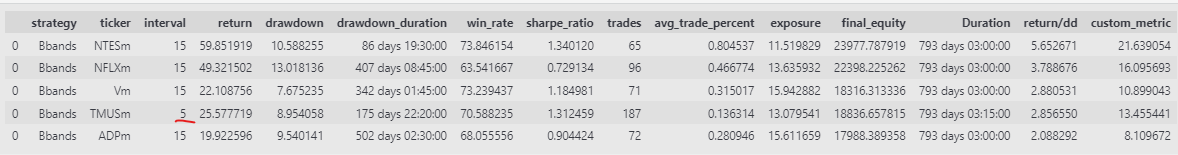
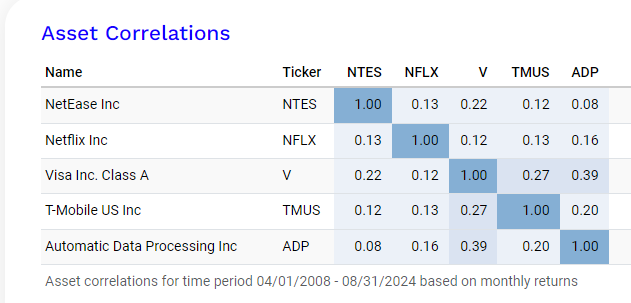

## Cryptos

['MATICUSDm', 'SNXUSDm', 'AAVEUSDm']
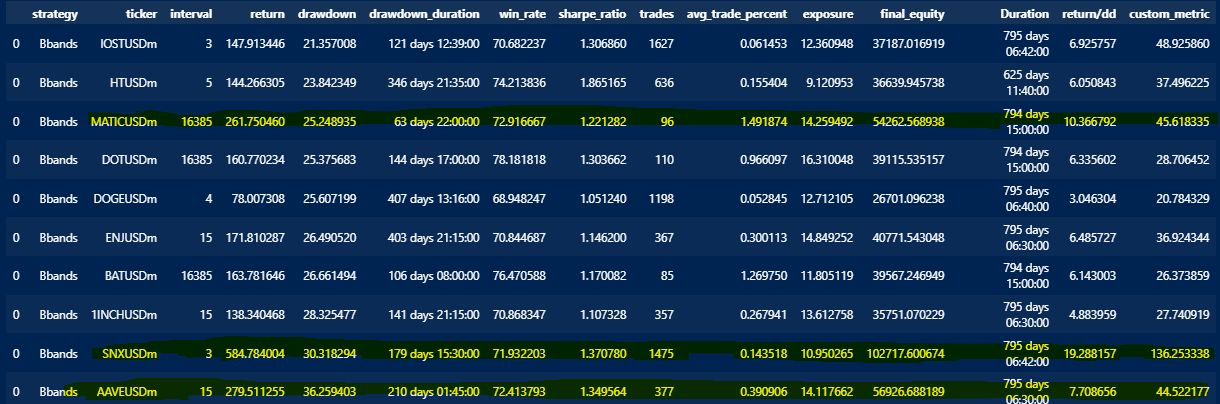

